In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy.io import fits
import photutils
import os
import pandas as pd
from astropy.cosmology import FlatLambdaCDM
import astropy.constants as const
import astropy.units as u
import statmorph
from astropy.visualization import simple_norm
from statmorph.utils.image_diagnostics import make_figure
from photutils.background import Background2D, MedianBackground
from astropy.convolution import convolve, Gaussian2DKernel
from photutils.segmentation import make_2dgaussian_kernel
from photutils.segmentation import detect_sources
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.segmentation import deblend_sources
from photutils.segmentation import SourceFinder
from photutils.segmentation import SourceCatalog
from astropy.visualization import LogStretch
from photutils.isophote import EllipseGeometry
from photutils.aperture import EllipticalAperture
from astropy.stats import sigma_clipped_stats
from photutils.aperture import ApertureStats, CircularAperture
from photutils.datasets import make_4gaussians_image
from photutils.aperture import aperture_photometry
from photutils.isophote import Ellipse
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.visualization import simple_norm
from scipy.optimize import leastsq
from scipy.optimize import fsolve
from scipy.optimize import minimize
import re
from astropy.modeling import models, fitting
from astropy.io import fits
from astropy.modeling.models import custom_model
from astropy.convolution import convolve_models
from scipy.signal import fftconvolve
from astropy.visualization import (
    ImageNormalize,
    MinMaxInterval,
    LogStretch,
    HistEqStretch,
    LinearStretch,
    ZScaleInterval,
)
from photutils.isophote import Ellipse, EllipseGeometry
import matplotlib.ticker as ticker
import copy
import sys
import os
import math
import logging
from basicfunc import *
import glob
from photutils.centroids import centroid_quadratic
from photutils.profiles import RadialProfile
from astropy.table import Table
# import galsim

plt.rcParams['figure.figsize'] = [16, 20]
plt.rcParams.update({'font.size': 15})
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'viridis'
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.style"] = "normal"

# from statmorph
class ConvolvedSersic(models.Sersic2D):
    """
    Two-dimensional Sersic surface brightness profile, convolved with
    a PSF provided by the user as a numpy array.

    See Also
    --------
    astropy.modeling.models.Sersic2D

    """

    psf = None

    @classmethod
    def set_psf(cls, psf):
        """
        Specify the PSF to be convolved with the Sersic2D model.
        """
        cls.psf = psf / np.sum(psf)  # make sure it's normalized

    @classmethod
    def evaluate(cls, x, y, amplitude, r_eff, n, x_0, y_0, ellip, theta):
        """
        Evaluate the ConvolvedSersic2D model.
        """
        z_sersic = models.Sersic2D.evaluate(
            x, y, amplitude, r_eff, n, x_0, y_0, ellip, theta
        )
        if cls.psf is None:
            raise AssertionError("Must specify PSF using set_psf method.")

        # Apparently, scipy.signal also wants double:
        return fftconvolve(np.float64(z_sersic), np.float64(cls.psf), mode="same")

def morph_est(img, psf0, sigma, plot=False):
    """
    estimate the morphology of the galaxy
    where
        img is the image of the galaxy
        psf is the psf of the image
        sigma is the noise level of the image (weightmap)
        mask is the maskmap of the image
    """
    bkg_estimator = MedianBackground()
    kernel = make_2dgaussian_kernel(3.0, size=5)  # FWHM = 3.0

    bkg = Background2D(img, (15,15), filter_size=(5, 5), bkg_estimator=bkg_estimator)
    data = img - bkg.background  # subtract the background

    threshold = 1.5 * bkg.background_rms
    convolved_data = convolve(data, kernel)

    finder = SourceFinder(npixels=9, progress_bar=False)
    segment_lab = finder(convolved_data, threshold)
    labelarr = segment_lab.data
    segmap = copy.deepcopy(labelarr)
    cent_label = labelarr[labelarr.shape[0]//2, labelarr.shape[1]//2]
    if cent_label != 0:
        segment_lab.remove_labels(cent_label)
        segmap[segmap != cent_label] = 0
        segmap[segmap == cent_label] = 1
    mask = segment_lab.data
    mask[mask>0] = 1

    mask_map = np.array(mask).astype(bool)
    source_morphs = statmorph.source_morphology(data, segmap, mask=mask_map, weightmap=sigma, psf=psf0)
    morph = source_morphs[0]

    if plot:
        try:
            fig = make_figure(morph)
            plt.show()
            plt.close(fig)
        except:
            print('failed to plot the morphology with morph_est')

    return morph

filter_wavelengths = {
    'F070W': 0.7, 'F090W': 0.9, 'F115W': 1.15,  'F150W': 1.5, 'F164N': 1.64, 'F105W': 1.055025, 'F125W': 1.248607, 'F140W': 1.392321, 'F160W': 1.537034, 
     'F200W': 2.0,'F277W': 2.77,  'F162M': 1.62, 'F182M': 1.82, "F187N": 1.87,
    'F300M': 3.0, 'F335M': 3.35, 'F356W': 3.56, 'F360M': 3.6, 'F210M': 2.1, 'F250M': 2.5, 'F410M': 4.1, 'F430M': 4.3, 'F140M': 1.4, 
    'F444W': 4.44, 'F460M': 4.6, 'F480M': 4.8, 'F435W': 0.435, 'F606W': 0.606, 'F775W': 0.775, 'F814W': 0.814
}

In [4]:
# psffiles = glob.glob('/Users/zijianzhang/Astro_Data/LRD_SPEC/Narrowline_LRD_image/uds_psf/*psf.fits')
# # psffiles
# # save 2nd extension to 1st extension fits
# for psffile in psffiles:
#     hdul = fits.open(psffile)
#     data = hdul[1].data
#     fits.writeto(psffile, data, hdul[0].header, overwrite=True)
#     hdul.close()
#     print(psffile)

In [3]:
# scale the error 
# convert err to weight
src_IDs = [8219,12329,16321,20547,22015]#[12329,15500,15504,16321,19937,20773,22015,8219,9656]
base_dir = '/Users/zijianzhang/Astro_Data/LRD_SPEC/Narrowline_LRD_image/'
for srcID in src_IDs:
    print('srcID:', srcID)
    if(srcID != 12329):
        continue
    ID_dir = base_dir + str(srcID) + '/'
    os.chdir(ID_dir)
    errfiles = glob.glob('*err.fits')
    errfiles.sort()

    for ii, errfile in enumerate(errfiles):
        datafile = errfile.replace('err', 'data')
        # make segmap and plot to see if it is correct
        hdul = fits.open(datafile)
        data = hdul[0].data
        bkg_estimator = MedianBackground()
        kernel = make_2dgaussian_kernel(3.0, size=5)  # FWHM = 3.0
        bkg = Background2D(data, (15,15), filter_size=(5, 5), bkg_estimator=bkg_estimator)
        data = data - bkg.background  # subtract the background
        threshold = 1.2 * bkg.background_rms
        convolved_data = convolve(data, kernel)
        finder = SourceFinder(npixels=10, progress_bar=False)
        segment_lab = finder(convolved_data, threshold)
        # try:
        labelarr = segment_lab.data
        # except:
        #     continue
        segmap = copy.deepcopy(labelarr)
        cent_label = labelarr[labelarr.shape[0]//2, labelarr.shape[1]//2]
        if cent_label != 0:
            segment_lab.remove_labels(cent_label)
            segmap[segmap != cent_label] = 0
            segmap[segmap == cent_label] = 1
        mask = segment_lab.data
        mask[mask>0] = 1
        mask_map = np.array(mask).astype(bool)

      
            # save as mask
        maskfile = errfile.replace('err', 'mask')
        fits.writeto(maskfile, mask_map.astype(int), hdul[0].header, overwrite=True)
        # fig, ax = plt.subplots(1, 2, figsize=(4, 4))
        # # plt.imshow(segmap)
        # ax[0].imshow(data, origin='lower', cmap='viridis')
        # ax[1].imshow(segmap, origin='lower', cmap='viridis')
        # plt.show()

        # scale the err such that its background pixel values roughly equal the standard deviation of the background pixel values of the science image (SCI extension)
        hdulerr = fits.open(errfile)
        err = hdulerr[0].data
        err_median = sigma_clipped_stats(err[~mask_map], sigma=3.0, maxiters=5)[1]
        data_std = sigma_clipped_stats(data[~mask_map], sigma=3.0, maxiters=5)[2]
        scale_factor = data_std/err_median
        print(scale_factor)
        err = err * scale_factor
        # save the err file
        errfile = errfile.replace('err', 'err_scale')
        fits.writeto(errfile, err, hdulerr[0].header, overwrite=True)

srcID: 8219
srcID: 12329
0.49619787787547187
0.49894299446705315
0.4922037126623611
0.48570705842208733
0.6815107232646558
0.6770249891883733
0.7107391529058505
0.6667537786628905
srcID: 16321
srcID: 20547
srcID: 22015


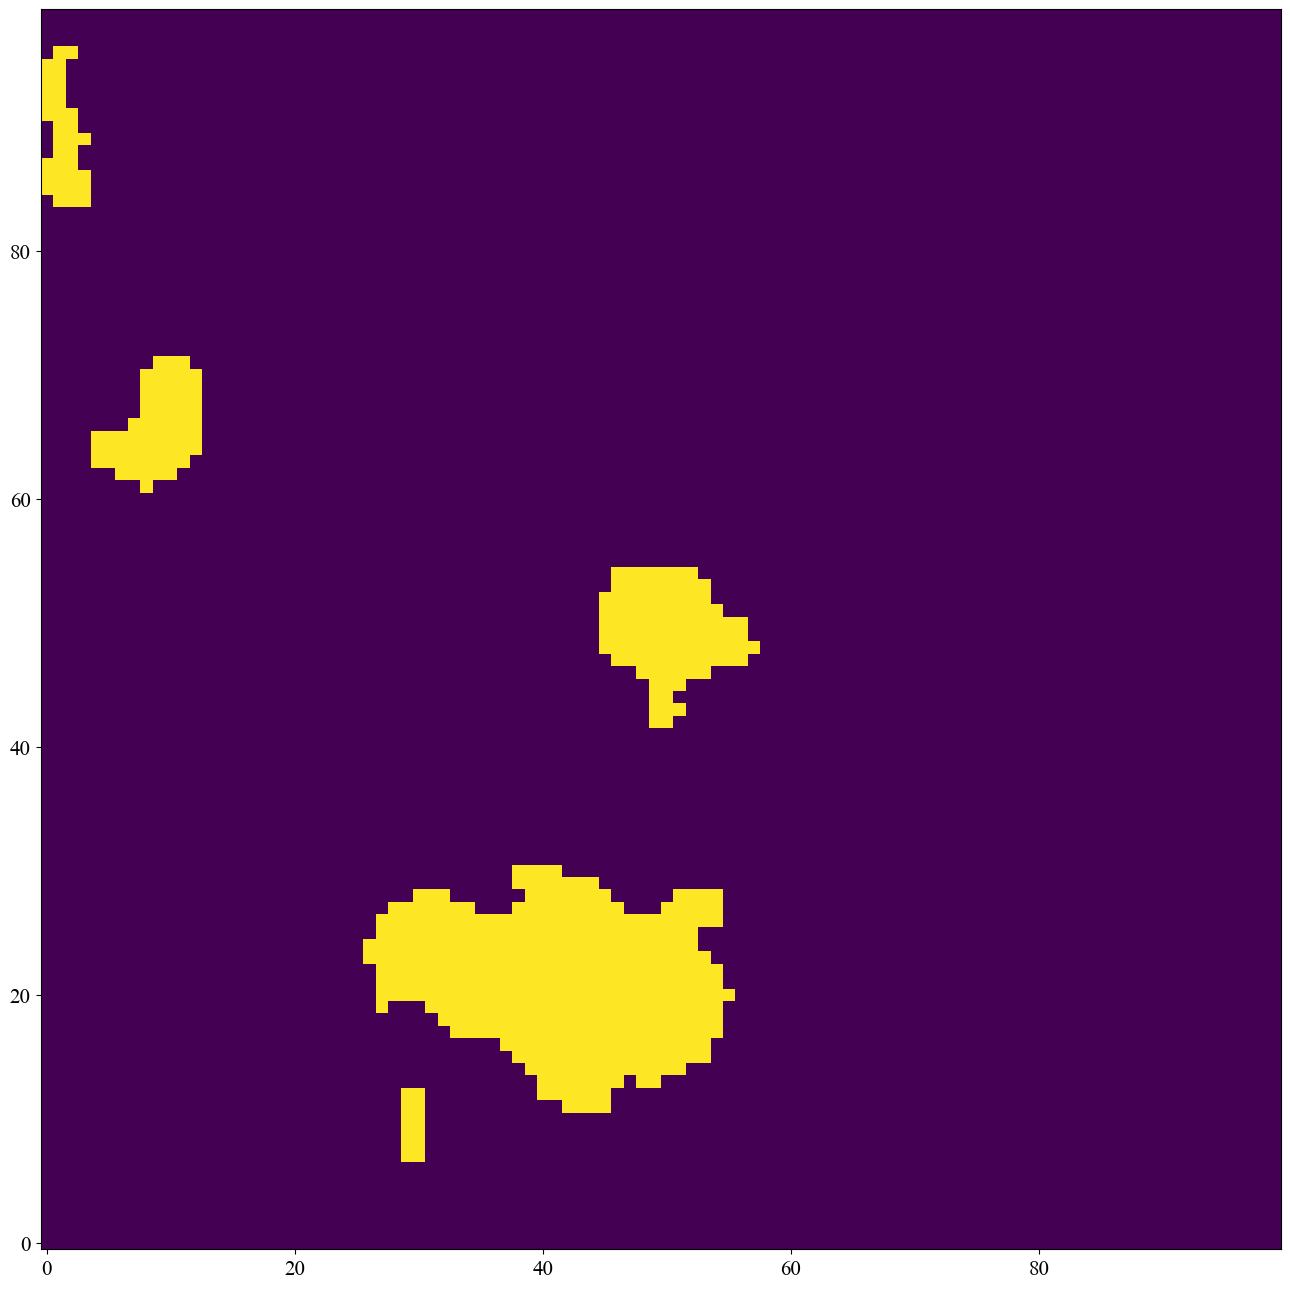

In [43]:
plt.imshow(segment_lab.data, origin='lower', cmap='viridis')

In [10]:
import warnings
import matplotlib.gridspec as gridspec
# ignore warnings
warnings.filterwarnings('ignore')

def get_surface_b(data, error, posi_list, pixscale, reff, ar, PA):
    
    ff = 0
    while(ff < len(posi_list)):
        try:
            geometry_psf = EllipseGeometry(x0=posi_list[ff][0], y0=posi_list[ff][1], sma=min(max(reff, 2.),5), eps=min(0.2, 1-ar), pa= deg2rad(90 - PA))     
            psf_ellipse_model = Ellipse(data, geometry_psf)
            psf_isolist_model = psf_ellipse_model.fit_image(fix_center=True, maxsma=10, step=0.1, minsma=0.0)        
            if(len(psf_isolist_model.sma) == 0 and np.any(np.isnan(psf_isolist_model.int_err))):
                break
            ff += 1
        except:
            ff += 1
            psf_isolist_model = None
    if(psf_isolist_model is not None and len(psf_isolist_model.sma) > 0):
        psf_model = 28.08651939228399- 2.5*np.log10(psf_isolist_model.intens / pixscale**2)
        sb_data_err_low = 28.08651939228399 - 2.5*np.log10((psf_isolist_model.intens + psf_isolist_model.int_err) / pixscale**2)
        sb_data_err_up = 28.08651939228399 - 2.5*np.log10((psf_isolist_model.intens - psf_isolist_model.int_err) / pixscale**2)
        psf_model_err = [psf_model-sb_data_err_low, sb_data_err_up-psf_model]
        # ax[s,0].plot(psf_isolist_model.sma * pixscale, psf_model, color='gray', label='psf model', ls = '--')
        return psf_isolist_model.sma * pixscale, psf_model, psf_model_err
    else:
        edge_radii = np.arange(0,15,0.5)
        xycen = centroid_quadratic(data)
        if(np.isnan(xycen[0])):
            xycen = [posi_list[ff][0], posi_list[ff][1]]
        # print(xycen)  
        rp = RadialProfile(data, xycen, edge_radii, error=error, mask=None)
        # rp.radius, rp.profile, yerr=rp.profile_error
        # psf_radius_, psf_intens_, psf_int_err_ = rp.radius, rp.profile, rp.profile_error
        psf_radius_ = rp.radius
        psf_intens_ = 28.08651939228399- 2.5*np.log10(rp.profile / pixscale**2)
        psf_int_up = 28.08651939228399- 2.5*np.log10((rp.profile + rp.profile_error) / pixscale**2)
        psf_int_low = 28.08651939228399- 2.5*np.log10((rp.profile - rp.profile_error) / pixscale**2)
        psf_int_err_ = [psf_intens_-psf_int_low, psf_int_up-psf_intens_]
        return psf_radius_* pixscale, psf_intens_, psf_int_err_
        # ax[s,0].plot(psf_radius * pixscale, 28.08651939228399- 2.5*np.log10(psf_intens / pixscale**2), color='gray', label='psf model', ls = '--')

def plot_galfitm_res(result_name, figure_name, numid_psf, num_comp, band_names,
                     img_idx , mask_file, pixscale, save=False, show=True):
    # band_names = bandnames
    # img_path = './'
    # figure_name = '15500_result.png'
    # numid_psf = 1
    # num_comp = 2
    # pixscale = 0.03
    # img_idx = band_names[0]
    # save = True
    # show = True
    # mask_file = '15500.mask.fits'
    if(num_comp == 2):
        hdu = fits.open(result_name)
        psf_mag_key = ['1_MAG_' + i for i in bandnames]
        sersic_mag_key = ['2_MAG_' + i for i in bandnames]
        psf_mags = []
        sersic_mags = []
        for i in range(len(psf_mag_key)):
            psf_mag = hdu[len(band_names)].header[psf_mag_key[i]].split(' ')[0].replace('*', '')
            sersic_mag = hdu[len(band_names)].header[sersic_mag_key[i]].split(' ')[0].replace('*', '')
            psf_mags.append(float(psf_mag))
            sersic_mags.append(float(sersic_mag))

        # 将星等转换为线性流量并计算AGN fraction
        agn_fractions = []
        for psf_mag, sersic_mag in zip(psf_mags, sersic_mags):
            # 星等转流量公式: flux = 10^(-0.4 * mag)
            flux_agn = 10 ** (-0.4 * psf_mag)
            flux_host = 10 ** (-0.4 * sersic_mag)

            # 计算AGN流量占总流量的比例
            total_flux = flux_agn + flux_host
            agn_fraction = flux_agn / total_flux if total_flux != 0 else 0.0  # 避免除零错误
            agn_fractions.append(agn_fraction)

    n_band = len(band_names)
    fig, ax = plt.subplots(n_band, 5)
    fig.set_size_inches(16, 3*n_band)

    # 删除原来的 ax[0,0] 并创建嵌套子图
    fig.delaxes(ax[0,0])  # 移除原有子图
    gs = ax[0,1].get_subplotspec().get_gridspec()  # 获取全局 gridspec
    for j in range(n_band):
        for k in range(5):
            ax[j,k ].set_xticks([])  # Remove x-axis ticks
            ax[j,k ].set_yticks([])  # Remove y-axis ticks
    # 在第一个位置创建嵌套子网格 (2行1列, 高度比5:1)
    ax_bottoms = []
    for j in range(n_band):
        sub_gs = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[j,0], height_ratios=[4,1])
        ax_top = fig.add_subplot(sub_gs[0])  # 上部 axes (5/6 高度)
        ax_bottom = fig.add_subplot(sub_gs[1])  # 下部 axes (1/6 高度)
        ax[j,0] = ax_top
        ax_bottoms.append(ax_bottom)

    # 其他原有配置保持不变
    fig.tight_layout()
    plt.subplots_adjust(wspace=0.01, hspace=0.01)
    titlefz = 18
    ax[0,0].set_title('Surface Brightness Profile', fontsize = titlefz)
    ax[0,1].set_title('data', fontsize = titlefz + 5)
    ax[0,2].set_title('model', fontsize = titlefz + 5)
    ax[0,3].set_title('data - psf', fontsize = titlefz + 5)
    ax[0,4].set_title('residual', fontsize = titlefz + 5)

    # for t in range(n_band):
    #     ax[t,0].set_ylabel(band_names[t])
    # qso_names = os.listdir(img_path)
    # fname = fetch_filename(img_idx, qso_names, idx=0, sept='-')
    # fname = fetch_filename(img_idx, qso_names, idx=1, sept='_')
    gal_res = fits.open(result_name)
    img0 = gal_res[0].data#fits.getdata(img_path + fname)
    datasize = img0.shape
    x_cent = (datasize[1]-1)/2
    y_cent = (datasize[0]-1)/2



            # ax[j,0].set_yticks([])

    j = n_band - 1
    for k in range(4):
        ax[j,k + 1].set_xticks([x_cent-0.5/pixscale, x_cent-0.25/pixscale, x_cent, x_cent+0.25/pixscale, x_cent+0.5/pixscale],[-0.5,-0.25,0,0.25,0.5])
        # ax[j,k].set_yticks([y_cent-0.5/pixscale, y_cent-0.25/pixscale, y_cent, y_cent+0.25/pixscale, y_cent+0.5/pixscale],[-0.5,-0.25,0,0.25,0.5])
    for j in range(4):
        ax[n_band -1 ,j + 1].set_xlabel('arcsec')


    for s in range(n_band):
        # if s != 4:
        #     continue
        # norm = ImageNormalize(stretch=LogStretch(a=10000), vmin=0, vmax=50)
        hd = gal_res[s + n_band].header
        data =  fits.getdata(hd['HIERARCH DATAIN_' + str.upper(band_names[s])])
        error = fits.getdata(hd['HIERARCH SIGMA_'  + str.upper(band_names[s])])

        FITSECT = hd['FITSECT']
        matches = re.findall(r'(\d+):(\d+)', FITSECT)
        norm = ImageNormalize(vmin=np.percentile(gal_res[s].data.flatten(), 5), 
                                                           vmax=np.percentile(gal_res[s].data.flatten(), 95))
        im1 = ax[s,1].imshow(gal_res[s].data, norm=norm)        # data
        # divider = make_axes_locatable(ax[s,0])
        # cax = divider.append_axes('right', size='2%', pad=0.02)
        # fig.colorbar(im1, cax=cax, orientation='vertical',format=ticker.LogFormatter())
        im2 = ax[s,2].imshow(gal_res[s + n_band].data, norm=norm)       # model
        # divider = make_axes_locatable(ax[s,1])
        # cax = divider.append_axes('right', size='2%', pad=0.02)
        # fig.colorbar(im2, cax=cax, orientation='vertical',format=ticker.LogFormatter())
        # fname = fetch_filename(img_idx + s*n_gal, qso_names, idx=0, sept='-')   
        band = band_names[s]
        fname = fetch_filename(img_idx, qso_names, idx=1, sept='_')

        mask = fits.getdata(mask_file)
        unmask_cent = copy.deepcopy(mask)
        x_cent = mask.shape[0]//2
        y_cent = mask.shape[1]//2
        unmask_cent[x_cent-3:x_cent+3, y_cent-3:y_cent+3] = 0
        numid_psf_model = numid_psf + 3*n_band -1 + s*num_comp
        im3 = ax[s,3].imshow(gal_res[s].data  - gal_res[numid_psf_model].data, norm=norm)     # masked_data - psf
        # divider = make_axes_locatable(ax[s,2])
        # cax = divider.append_axes('right', size='2%', pad=0.02)
        # fig.colorbar(im3, cax=cax, orientation='vertical',format=ticker.LogFormatter())
        residual = gal_res[s + 2*n_band].data/error[int(matches[0][0]) - 1:int(matches[0][1]), int(matches[1][0]) - 1:int(matches[1][1]) ]     #* (1-unmask_cent)
        max_val = max(np.max(residual), -np.min(residual))
        im4 = ax[s,4].imshow(residual, cmap='seismic', origin='lower', vmin=-max_val, vmax=max_val)     # masked_residual
        divider = make_axes_locatable(ax[s,4])
        cax = divider.append_axes('right', size='2%', pad=0.02)
        fig.colorbar(im4, cax=cax, orientation='vertical')
        # numid_sersic = numid_psf + 1
        numid_sersic = 2


        try:
            ar = float(hd[str(numid_sersic)+ '_AR_'+ str.upper(band_names[s])].split(' ')[0].replace('*',''))
            PA = float(hd[str(numid_sersic)+ '_PA_'+ str.upper(band_names[s])].split(' ')[0].replace('*',''))
        except:
            ar = 1
            PA = 0
        try:
            reff = float(hd[str(numid_sersic)+ '_RE_'+ str.upper(band_names[s])].split(' ')[0])
        except:
            try:
                reff = float(hd[str(numid_sersic)+ '_RE_0'].split(' ')[0])
            except:
                reff = 1

        xycen = centroid_quadratic(gal_res[3*n_band + num_comp*s].data)
        
        positions_psf = [float(hd[str(numid_psf) + '_XC_'+str.upper(band_names[s])].split(' ')[0].replace('*',''))- int(matches[0][0]), 
            float(hd[str(numid_psf) + '_YC_'+str.upper(band_names[s])].split(' ')[0].replace('*','')) - int(matches[1][0])]
        positions_psf_origin = [float(hd[str(numid_psf) + '_XC_'+str.upper(band_names[s])].split(' ')[0].replace('*','')), 
            float(hd[str(numid_psf) + '_YC_'+str.upper(band_names[s])].split(' ')[0].replace('*','')) ]
        if(num_comp == 2):
            positions_ser = [float(hd[str(numid_sersic) + '_XC_'+str.upper(band_names[s])].split(' ')[0].replace('*',''))- int(matches[0][0]), 
                            float(hd[str(numid_sersic) + '_YC_'+str.upper(band_names[s])].split(' ')[0].replace('*','')) - int(matches[1][0])]
            posi_list = [positions_ser, xycen, positions_psf]
        else:
            posi_list = [xycen, positions_psf]

        edge_radii = np.arange(0,15,0.5)
        # edge_radii = 

        # data[data<0] = data[data<0]/1.1
        xycen = centroid_quadratic(data)
        if(np.isnan(xycen[0]) or np.abs(xycen[0] - positions_psf_origin[0]) > 4 or np.abs(xycen[1] - positions_psf_origin[1]) > 4):
            xycen = [positions_psf_origin[0], positions_psf_origin[1]]
        print(xycen)  
        rp = RadialProfile(data, xycen, edge_radii, error=error, mask=None)
        # rp.radius, rp.profile, yerr=rp.profile_error
        data_radius, data_intens, data_int_err = rp.radius, rp.profile, rp.profile_error
        if(len(np.where(data_intens < 0)[0]) > 0):
            neg_ind = np.where(~(data_intens > 0))[0][0]
            data_radius, data_intens, data_int_err = data_radius[:neg_ind], data_intens[:neg_ind], data_int_err[:neg_ind]
        # data_intens[data_intens < 0] = 0.
        sb_data = 28.08651939228399- 2.5*np.log10(data_intens / pixscale**2)
        sb_data_err_low = 28.08651939228399 - 2.5*np.log10((data_intens + data_int_err) / pixscale**2)
        sb_data_err_up = 28.08651939228399 - 2.5*np.log10((data_intens - data_int_err) / pixscale**2)
        err1 = np.nan_to_num(sb_data-sb_data_err_low, nan=10)
        err2 = np.nan_to_num(sb_data_err_up-sb_data, nan=10)
        sb_data_err = [err1, err2]


        error = error[int(matches[0][0]) - 1:int(matches[0][1]), int(matches[1][0]) - 1:int(matches[1][1])]

        model_radius, model_intens, model_int_err = get_surface_b(gal_res[s + n_band].data,error, posi_list,pixscale, reff, ar, PA)
        if(np.any(np.array(model_int_err) <0) or np.any(np.isnan(model_int_err))):
            model_radius, model_intens, model_int_err = get_surface_b(gal_res[s + n_band].data, error,posi_list,pixscale, 3, ar, PA)
        if(np.any(np.array(model_int_err) <0) or np.any(np.isnan(model_int_err))):
            model_radius, model_intens, model_int_err = get_surface_b(gal_res[s + n_band].data,error, posi_list, pixscale,300, ar, PA)

        # ----------------- psf fitting example --------------
        psf_radius, psf_intens, psf_int_err = get_surface_b(gal_res[3*n_band + num_comp*s].data,error, posi_list, pixscale,reff, ar, PA)
        # ----------------- psf fitting example --------------
        if(num_comp == 2):
            sersic_radius, sersic_intens, sersic_int_err = get_surface_b(gal_res[3*n_band + num_comp*s + 1].data,error, posi_list, pixscale,reff, ar, PA)

        bkg_estimator = MedianBackground()
        kernel = make_2dgaussian_kernel(3.0, size=5)  # FWHM = 3.0
        bkg = Background2D(data, (15,15), filter_size=(5, 5), bkg_estimator=bkg_estimator)
        bkg_rms_median = bkg.background_rms_median
        bkg_rms_sb = 28.08651939228399- 2.5*np.log10(bkg_rms_median / pixscale**2)

        ax[s,0].axhline(bkg_rms_sb, color='black', ls='--', label = 'background')
        ax[s,0].errorbar(data_radius * pixscale, sb_data, yerr=sb_data_err, fmt='o', label='data', color='black', markerfacecolor='none', markersize=10)
        ax[s,0].plot(model_radius, model_intens,  color='blue', label='model')
        ax[s,0].fill_between(model_radius, model_intens - model_int_err[0], model_intens + model_int_err[1], color='blue', alpha=0.3)
        ax[s,0].plot(psf_radius, psf_intens, color='gray', label='psf model', ls = '--')
        if(num_comp == 2):
            ax[s,0].plot(sersic_radius, sersic_intens, color='green', label='sersic model', ls = ':')


        ax[s,0].set_xlim(0, 10*pixscale)
        try:
            ax[s,0].set_ylim(min(sb_data) - 1, 31)
        except:
            ax[s,0].set_ylim(min(model_intens) - 1, 31)
        # ax[s,4].s
        #set yaxis ticks
        ax[s,0].yaxis.set_major_locator(ticker.MultipleLocator(1))
        ax[s,0].xaxis.set_major_locator(ticker.MultipleLocator(0.05))
        ax[s,0].xaxis.set_minor_locator(ticker.MultipleLocator(0.01))
        ax[s,0].text(0.7, 0.91, band_names[s], fontsize=20, color='black', transform=ax[s,0].transAxes)
        ax[s,0].text(0.7, 0.78, r'$\chi^2_{\nu}$ = %.2f' % hd['CHI2NU'], fontsize=15, color='black', transform=ax[s,0].transAxes)
        if(num_comp == 2):
            ax[s,0].text(0.65, 0.65, r'$f_{\rm PSF} = %.2f$' % agn_fractions[s], fontsize=15, color='black', transform=ax[s,0].transAxes)
        if(s == n_band - 2):
            total_chi = Table.read(result_name, 'FIT_INFO')['CHI2NU'].value[0]
            ax[s,0].text(0.05, 0.03, r'$\chi^2_{\nu}$ = %.2f (all bands)' % total_chi, fontsize=20, color='black', transform=ax[s,0].transAxes)

        ax[s,0].set_ylabel(r'$\mu$ (mag arcsec$^{-2}$)')

        # plot residual
        interp_model = np.interp(data_radius * pixscale, model_radius, model_intens)
        residual = sb_data - interp_model
        ax_bottoms[s].errorbar(data_radius * pixscale, residual, yerr=sb_data_err, fmt='o', color='black', markerfacecolor='none', markersize=10)
        ax_bottoms[s].axhline(0, color='black', ls='--')
        ax_bottoms[s].set_xlim(0, 10*pixscale)
        ax_bottoms[s].set_ylim(-1.5, 1.5)
        ax_bottoms[s].set_xlabel('arcsec')
        ax_bottoms[s].set_ylabel(r'$\Delta \mu$')
        ax_bottoms[s].xaxis.set_major_locator(ticker.MultipleLocator(0.1))
        # try:
        #     index = (np.abs(isolist_data.sma - 10)).argmin()
        #     y_up_cut = 28.08651939228399- 2.5*np.log10(isolist_data.intens[index] / pixscale**2)
        #     ax[s,4].set_ylim( top = y_up_cut+0.5 )
        # except:
        #     print('failed ellipse fitting of photutils') 
        #     index = (np.abs(isolist_model.sma - 10)).argmin()
        #     y_up_cut = 28.08651939228399- 2.5*np.log10(isolist_model.intens[index] / pixscale**2)
        #     ax[s,4].set_ylim( top = y_up_cut+0.5 )
        ax[s,0].invert_yaxis()
        if(s == n_band - 1):
            ax[s,0].legend(fontsize=10, ncols = 2, loc = 'lower left')
            # ax[s,0].set_xlabel('arcsec')
        # if(s == 3):
        #     raise
    # plt.tight_layout()
    for j in range(n_band):
        if(j < n_band  - 1):
            ax_bottoms[j].set_xticks([])
            for k in range(4):
                ax[j,k + 1].set_xticks([])  # Remove x-axis ticks
                ax[j,k + 1].set_yticks([])  # Remove y-axis ticks

        ax[j,0].set_xticks([])

    if save:
        fig.savefig(figure_name, dpi=300, bbox_inches='tight')

    if show:
        plt.show()
    plt.close(fig)

In [5]:
base_dir = '/Users/zijianzhang/Astro_Data/LRD_SPEC/Narrowline_LRD_image/'
os.chdir(base_dir)
src_IDs = [8219,12329,16321,20547,22015]#[12329,15500,15504,16321,19937,20773,22015,8219,9656]
#os.listdir(base_dir)

In [9]:
for srcID in src_IDs:
    print('srcID:', srcID)
    if(srcID != 12329):
        continue
    ID_dir = base_dir + str(srcID) + '/'
    os.chdir(ID_dir)
    datafiles = glob.glob('*data.fits')
    feedme_name = str(srcID) + '_galfitm.feedme'
    bandnames = [i.split('_')[1].upper() for i in datafiles]
    bandnames.sort()
    Band_names = bandnames
    print(bandnames)
    img_path = ''
    sig_path = ''
    psf_path = '/Users/zijianzhang/Astro_Data/LRD_SPEC/Narrowline_LRD_image/uds_psf/'
    mask_path = ''
    fit_region = [(25,75), (25,75)]

    mask_file =  str(srcID) + '.mask.fits'
    hdul = fits.open(datafiles[0])
    err = hdul[0].data
    mask = np.zeros_like(err)
    fits.writeto(mask_file, mask, hdul[0].header, overwrite=True)
    hdul.close()

    n_gal = 3
    num_comp = 2
    img_idx = '0'
    qso_names = datafiles
    # result_name = str(srcID) + '_result_psf.fits'
    # figure_name = str(srcID) + '_result_psf.png'
    result_name = str(srcID) + '_result.fits'
    figure_name = str(srcID) + '_result.png'
    pix_scale = 0.03
    
    hsc_waves = [filter_wavelengths[i]*1e4 for i in bandnames]

    gen_galfitm_feedme(feedme_name, img_idx, qso_names, n_gal, bandnames, Band_names, img_path,
        sig_path, psf_path, mask_path, mask_file, result_name, pix_scale, hsc_waves, fit_region = fit_region,
        iter_n=1, pre_res=None, numid_psf=1, num_comp=2)
    
    cmd = '/Users/zijianzhang/software/galfitm ' +  feedme_name
    os.system(cmd)

    print('printing')
    plot_galfitm_res(result_name, figure_name = figure_name, numid_psf = 1, num_comp = num_comp, band_names = bandnames,
                     img_idx= bandnames[0], mask_file = mask_file, pixscale = 0.03, save=True, show=False)

srcID: 8219
srcID: 12329
['F090W', 'F115W', 'F150W', 'F200W', 'F277W', 'F356W', 'F410M', 'F444W']
0 F090W
1 F115W
2 F150W
3 F200W
4 F277W
5 F356W
6 F410M
7 F444W

GALFITM Version galfitm-1.4.4
(based on GALFIT Version 3.0.5)


#  Input menu file: 12329_galfitm.feedme

# IMAGE and GALFIT CONTROL PARAMETERS
A) 12329_F090W_data.fits,12329_F115W_data.fits,12329_F150W_data.fits,12329_F200W_data.fits,12329_F277W_data.fits,12329_F356W_data.fits,12329_F410M_data.fits,12329_F444W_data.fits      # Input data image (FITS file)
A1) F090W,F115W,F150W,F200W,F277W,F356W,F410M,F444W     # Band labels
A2) 9000.00,11500.0,15000.0,20000.0,27700.0,35600.0,41000.0,44400.0     # Band wavelengths
B) 12329_result.fits      # Output data image block
C) 12329_F090W_err_scale.fits,12329_F115W_err_scale.fits,12329_F150W_err_scale.fits,12329_F200W_err_scale.fits,12329_F277W_err_scale.fits,12329_F356W_err_scale.fits,12329_F410M_err_scale.fits,12329_F444W_err_scale.fits 0.000   # Sigma image and min. sigma factor (m

In [51]:
bandnames

['F090W', 'F115W', 'F150W', 'F200W', 'F277W', 'F356W', 'F410M', 'F444W']

In [ ]:
pwd


'/Users/zijianzhang/Astro_Data/LRD_SPEC/Narrowline_LRD_image/12329'

In [12]:
srcID = 12329
ID_dir = base_dir + str(srcID) + '/'
os.chdir(ID_dir)

result_name = str(srcID) + '_result.fits'
figure_name = str(srcID) + '_result.png'
plot_galfitm_res(result_name, figure_name = figure_name, numid_psf = 1, num_comp = 1, band_names = bandnames,
                     img_idx= bandnames[0], mask_file = mask_file, pixscale = 0.03, save=True, show=False)

[49.8322, 51.187]
[49.6437696  50.29123014]
[49.7323, 51.2791]
[48.39873631 50.39528196]
[48.85084778 49.9354985 ]
[48.42705678 50.41811531]
[48.41832706 50.37611548]
[47.97214416 50.52222833]


In [95]:
os.chdir('/Users/zijianzhang/Astro_Data/LRD_SPEC/Narrowline_LRD_image/12329/')
result_name = '12329_result.fits'
hdu = fits.open(result_name)
#查看文件目录
hdu.info()
hdu[8].header

Filename: 12329_result.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  INPUT_F090W    1 PrimaryHDU      37   (51, 51)   float32   
  1  INPUT_F115W    1 ImageHDU        38   (51, 51)   float32   
  2  INPUT_F150W    1 ImageHDU        38   (51, 51)   float32   
  3  INPUT_F200W    1 ImageHDU        38   (51, 51)   float32   
  4  INPUT_F277W    1 ImageHDU        38   (51, 51)   float32   
  5  INPUT_F356W    1 ImageHDU        38   (51, 51)   float32   
  6  INPUT_F410M    1 ImageHDU        38   (51, 51)   float32   
  7  INPUT_F444W    1 ImageHDU        38   (51, 51)   float32   
  8  MODEL_F090W    1 ImageHDU       274   (51, 51)   float32   
  9  MODEL_F115W    1 ImageHDU       274   (51, 51)   float32   
 10  MODEL_F150W    1 ImageHDU       274   (51, 51)   float32   
 11  MODEL_F200W    1 ImageHDU       274   (51, 51)   float32   
 12  MODEL_F277W    1 ImageHDU       274   (51, 51)   float32   
 13  MODEL_F356W    1 ImageHDU       274   (51, 51)   float32   


XTENSION= 'IMAGE   '           / IMAGE extension                                
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / Number of axes                                 
NAXIS1  =                   51 / Length of data axis 1                          
NAXIS2  =                   51 / Length of data axis 2                          
PCOUNT  =                    0 / number of random group parameters              
GCOUNT  =                    1 / number of random groups                        
WCSAXES =                    2 / Number of coordinate axes                      
CRPIX1  =     -10485.317490617 / Pixel coordinate of reference point            
CRPIX2  =      5095.6815216285 / Pixel coordinate of reference point            
PC1_1   =                 -1.0 / Coordinate transformation matrix element       
CDELT1  =  8.3333333333333E-06 / [deg] Coordinate increment at reference point  
CDELT2  =  8.3333333333333E-

In [78]:
dir_ = '/Users/zijianzhang/Astro_Data/LRD_SPEC/Narrowline_LRD_image/15500/'
os.chdir(dir_)
result_name = '15500_result_sersic.fits'
figure_name = '15500_result_sersic.png'
mask_file = '15500.mask.fits'

plot_galfitm_res(result_name, figure_name = figure_name, numid_psf = 1, num_comp = 1, band_names = bandnames,
                     img_idx= bandnames[0], mask_file = mask_file, pixscale = 0.03, save=True, show=False)

[50.6934, 50.8598]
[50.77, 50.8031]
[50.8772, 50.7238]
[49.97714147 49.62553199]
[50.58663547 49.02937993]
[51.0189065  49.05074782]
[50.85487949 48.89183627]


In [79]:
hdu[7].header

XTENSION= 'IMAGE   '           / IMAGE extension                                
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / Number of axes                                 
NAXIS1  =                   51 / Length of data axis 1                          
NAXIS2  =                   51 / Length of data axis 2                          
PCOUNT  =                    0 / number of random group parameters              
GCOUNT  =                    1 / number of random groups                        
WCSAXES =                    2 / Number of coordinate axes                      
CRPIX1  =             -18121.5 / Pixel coordinate of reference point            
CRPIX2  =              10857.5 / Pixel coordinate of reference point            
PC1_1   =                 -1.0 / Coordinate transformation matrix element       
CDELT1  =  8.3333333333333E-06 / [deg] Coordinate increment at reference point  
CDELT2  =  8.3333333333333E-

In [83]:
for s in range(7):
    print(hdu[s + 7].header['CHI2NU'])


0.263679083247555
0.254517034809147
0.240299473053519
0.486161680448109
0.480890670518157
0.508217892075591
0.522352672595002


In [103]:
psf_mag_key = ['1_MAG_' + i for i in bandnames]
sersic_mag_key = ['2_MAG_' + i for i in bandnames]

psf_mags = []
sersic_mags = []
for i in range(len(psf_mag_key)):
    psf_mag = hdu[8].header[psf_mag_key[i]].split(' ')[0].replace('*', '')
    sersic_mag = hdu[8].header[sersic_mag_key[i]].split(' ')[0].replace('*', '')
    psf_mags.append(float(psf_mag))
    sersic_mags.append(float(sersic_mag))

# 将星等转换为线性流量并计算AGN fraction
agn_fractions = []
for psf_mag, sersic_mag in zip(psf_mags, sersic_mags):
    # 星等转流量公式: flux = 10^(-0.4 * mag)
    flux_agn = 10 ** (-0.4 * psf_mag)
    flux_host = 10 ** (-0.4 * sersic_mag)
    
    # 计算AGN流量占总流量的比例
    total_flux = flux_agn + flux_host
    agn_fraction = flux_agn / total_flux if total_flux != 0 else 0.0  # 避免除零错误
    agn_fractions.append(agn_fraction)

# 输出结果（示例）
for band, frac in zip(bandnames, agn_fractions):
    psf_mag = psf_mags[bandnames.index(band)]
    sersic_mag = sersic_mags[bandnames.index(band)]
    print(f"{band}: psf mag = {psf_mag:.2f}, sersic mag = {sersic_mag:.2f}")
    print(f"AGN Fraction = {frac:.4f}")

F090W: psf mag = 29.34, sersic mag = 29.48
AGN Fraction = 0.5313
F115W: psf mag = 29.11, sersic mag = 28.62
AGN Fraction = 0.3894
F150W: psf mag = 28.82, sersic mag = 29.71
AGN Fraction = 0.6932
F200W: psf mag = 28.53, sersic mag = 28.76
AGN Fraction = 0.5522
F277W: psf mag = 28.70, sersic mag = 26.97
AGN Fraction = 0.1698
F356W: psf mag = 26.99, sersic mag = 26.54
AGN Fraction = 0.3980
F410M: psf mag = 26.42, sersic mag = 28.19
AGN Fraction = 0.8361
F444W: psf mag = 27.46, sersic mag = 26.08
AGN Fraction = 0.2185


[50.5246, 50.7675]
[50.6288, 50.7008]
[50.7747, 50.6075]
[49.97714147 49.62553199]
[50.58663547 49.02937993]
[51.0189065  49.05074782]
[50.85487949 48.89183627]


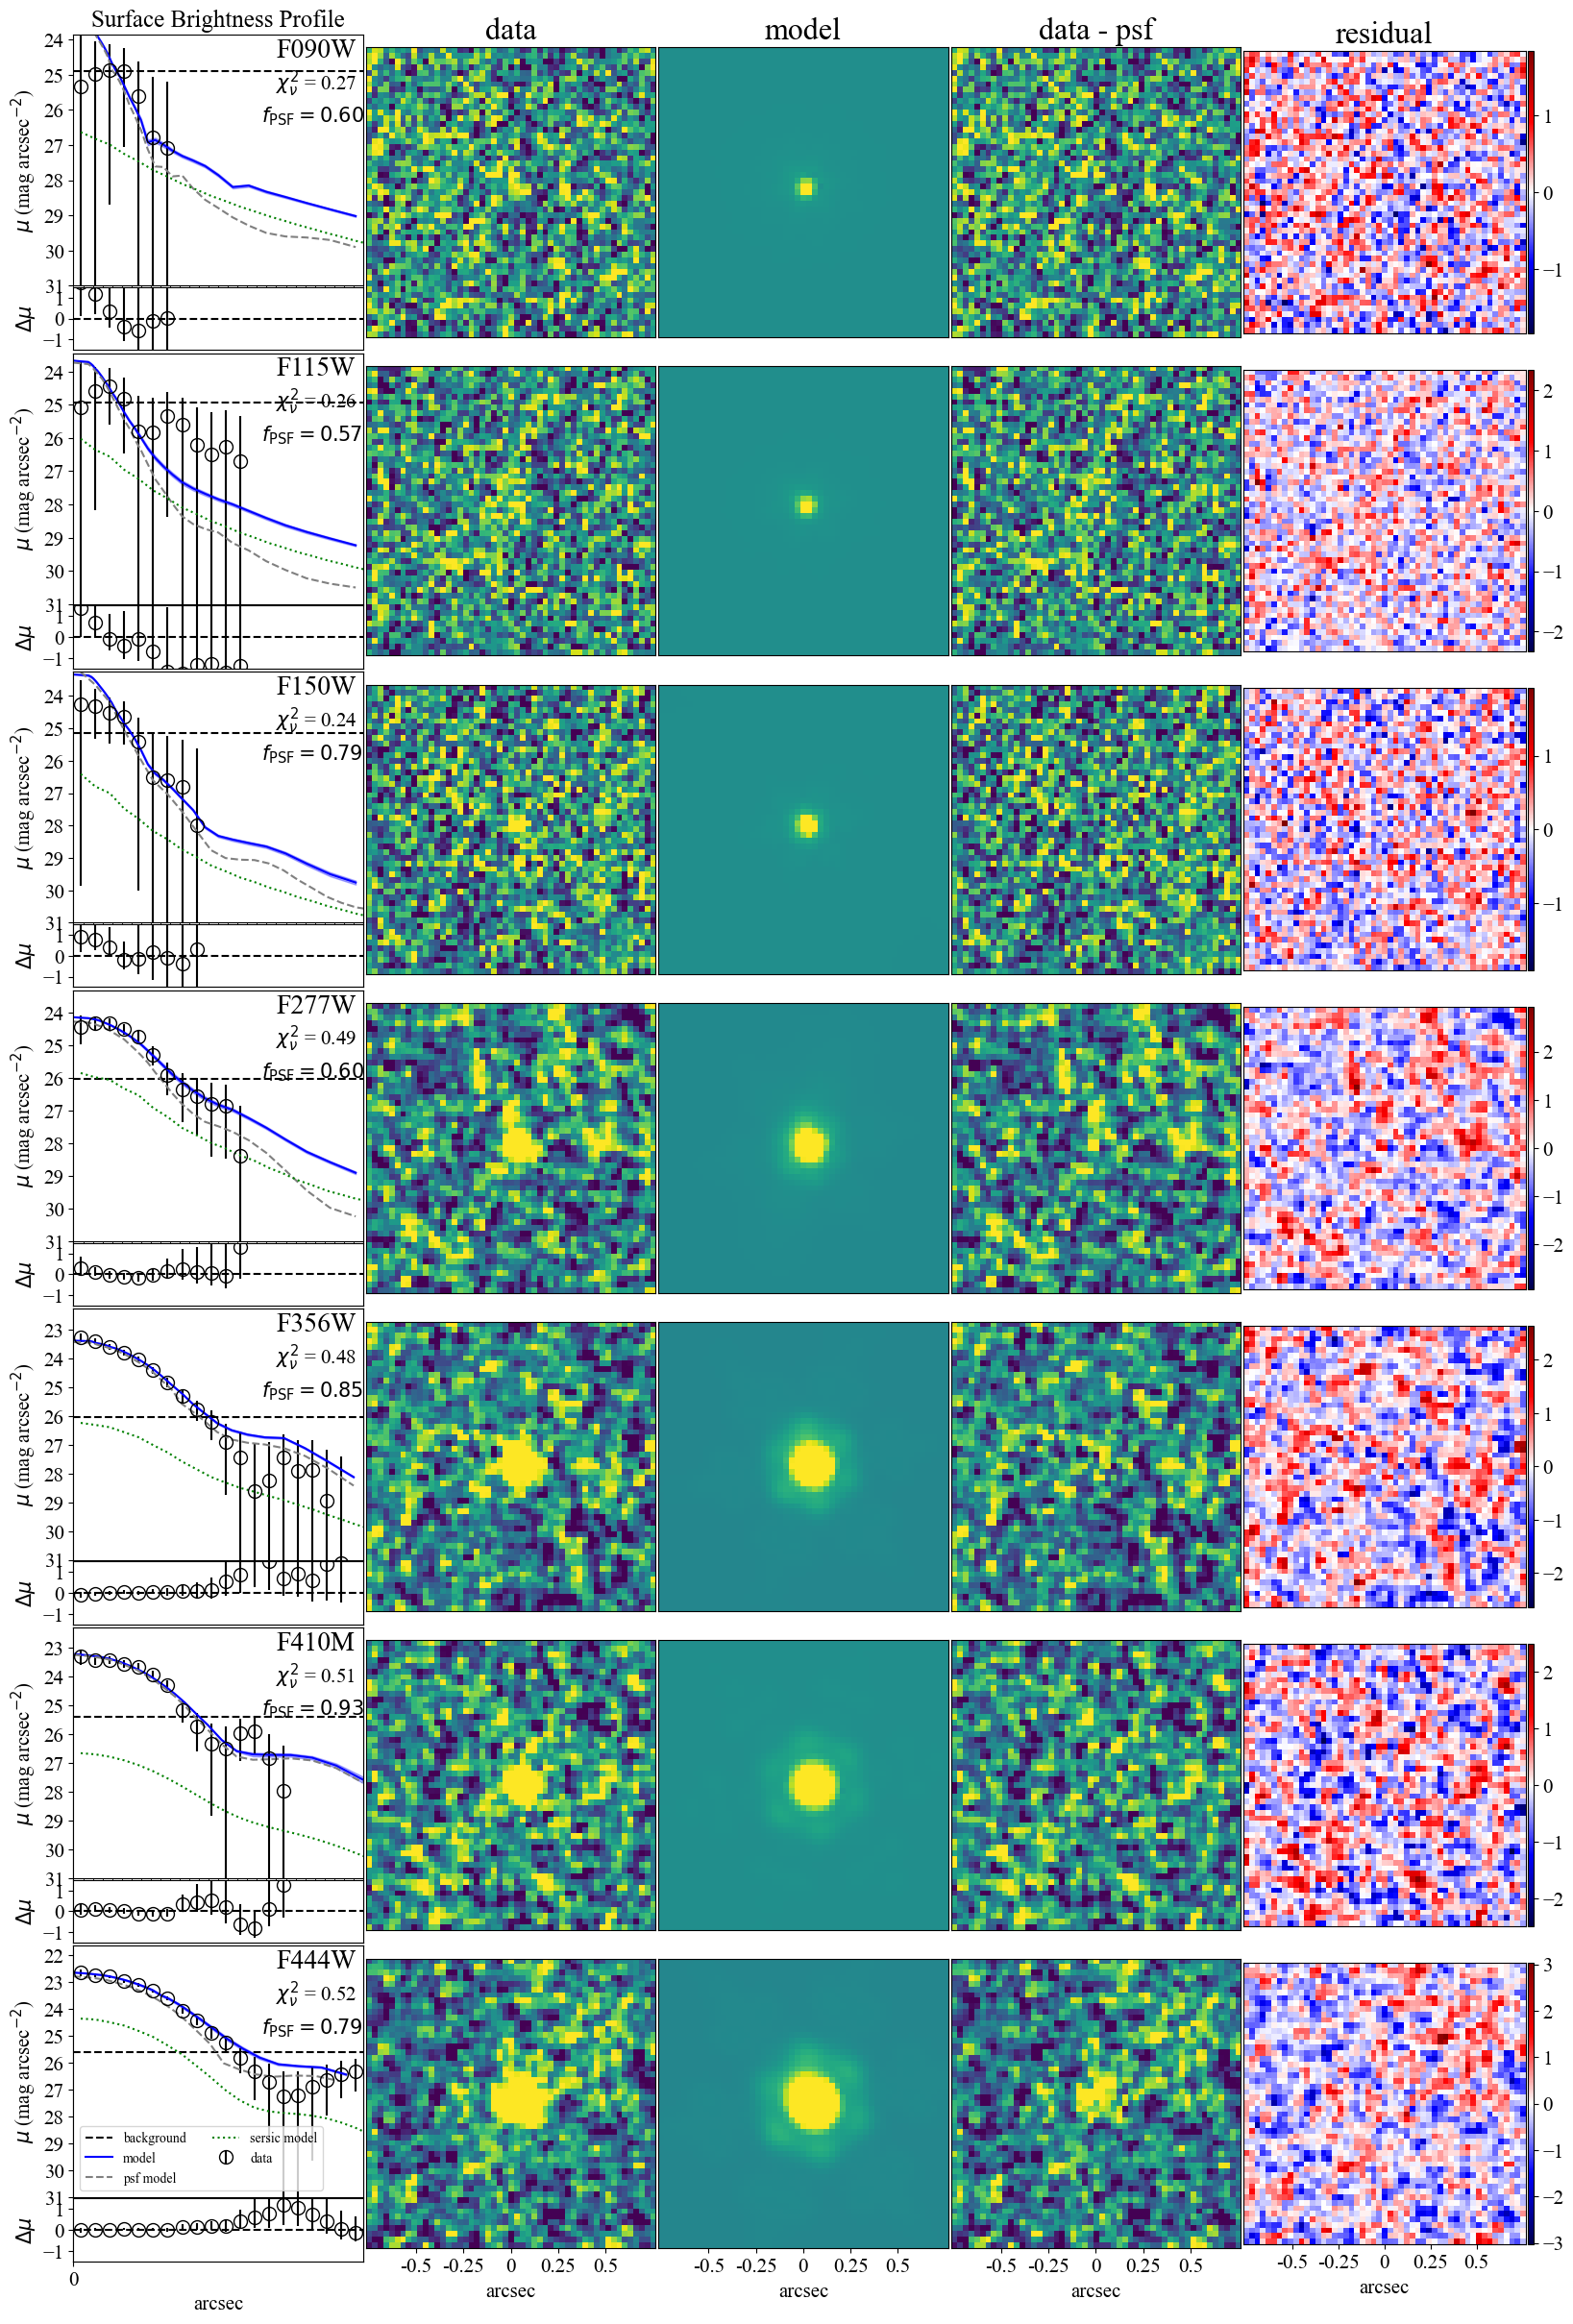

In [39]:
plot_galfitm_res(result_name, figure_name = '15500_result.png', numid_psf = 1, num_comp = 2, band_names = bandnames,
                     img_idx= bandnames[0], mask_file = mask_file, pixscale = 0.03, save=True, show=True)

In [138]:
s = 6
band = band_names[s]
data = gal_res[s].data
# psf = gal_res[25].data
psf = fits.getdata(hdu[11].header['PSF_' + band])
weight = fits.getdata(hdu[11].header['SIGMA_' + band])
x, y = np.meshgrid(np.arange(data.shape[1]), np.arange(data.shape[0]))
nx = data.shape[1]
ny = data.shape[0]

# 初始化模型
sersic_init = ConvolvedSersic(          
    amplitude=5.0,
    r_eff=5,
    n=2.0,
    x_0= nx/2,
    y_0= ny/2,
    ellip=0.3,
    theta=-20.0 / 180 * np.pi,
)
sersic_init.set_psf(psf)
# 选用Levenberg-Marquardt algorithm，可用的非线性fitter参考 https://docs.astropy.org/en/stable/modeling/fitting.html#notes-on-non-linear-fitting
fit_sersic = fitting.LevMarLSQFitter(calc_uncertainties = False)   
# 开始拟合
sersic_bestfit = fit_sersic(sersic_init, x, y, data, weights=weight, maxiter=1000)
# print(fit_sersic.fit_info["message"])


{'amplitude': 2.407384606726316, 'r_eff': 0.821155401244843, 'n': 2.6005489797160206, 'x_0': 25.016380441625625, 'y_0': 24.980475308116656, 'ellip': 0.9678760974724162, 'theta': -1.5931246371052636}


/var/folders/90/lqqkvnsn5f37_hff3d_g5ccc0000gn/T/ipykernel_75361/3897344263.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  matplotlib.cm.get_cmap("Greys_r").set_bad(color="red")


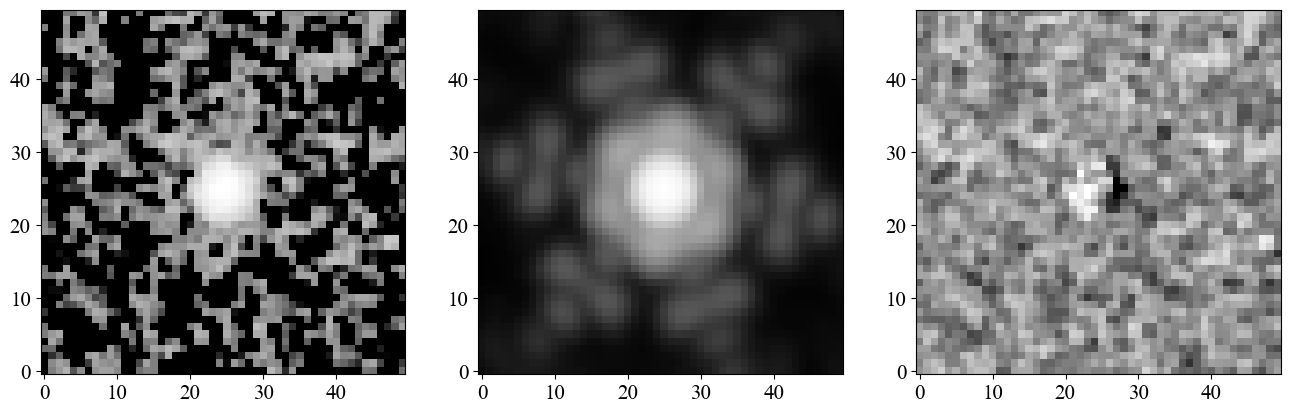

In [139]:


# 打印拟合好的参数
# print(np.mean(fit_sersic.fit_info["param_cov"] / fit_sersic.fit_info["cov_x"]))
# print(sersic_bestfit.__dict__)
print(dict(zip(sersic_bestfit.param_names, sersic_bestfit.parameters)))
# 比较数据和模型图像
eval_sersic_bestfit = sersic_bestfit(x, y)
residual = data - eval_sersic_bestfit
residual = np.ma.array(residual, mask=mask)
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
matplotlib.cm.get_cmap("Greys_r").set_bad(color="red")
norm = ImageNormalize(vmin=0, vmax=np.nanmax(data[mask == 0]), stretch=LogStretch())
resi_norm = ImageNormalize(
    residual, stretch=LinearStretch(), interval=ZScaleInterval()
)  # vmin=np.nanmin(residual), vmax=np.nanmax(residual))
axes[0].imshow(data, norm=norm, cmap="Greys_r")
axes[1].imshow(eval_sersic_bestfit, norm=norm, cmap="Greys_r")
axes[2].imshow(residual, norm=resi_norm, cmap="Greys_r")


In [134]:
sersic_bestfit.theta.value

-1.5931246371052636

In [135]:
data_masked = np.ma.array(data, mask=mask)
geo = EllipseGeometry(
    x0=sersic_bestfit.x_0.value,
    y0=sersic_bestfit.y_0.value,
    sma=sersic_bestfit.r_eff.value,
    eps=sersic_bestfit.ellip.value,
    pa=sersic_bestfit.theta.value,
)
geo.find_center(data_masked)

ellipse_data = Ellipse(data_masked, geo)
isolist_data = ellipse_data.fit_image(
    fix_center=True, maxsma=20
)
# ellipse_model = Ellipse(eval_sersic_bestfit, geo)
# isolist_model = ellipse_model.fit_image(
#     fix_center=True, maxsma=20
# )
print(isolist_data.to_table())
# print(isolist_model.to_table())



INFO: Found center at x0 =  25.0, y0 =  25.0 [photutils.isophote.geometry]
sma intens intens_err ellipticity ... ndata nflag niter stop_code
                                  ...                            
--- ------ ---------- ----------- ... ----- ----- ----- ---------


In [121]:
isolist_data.sma

array([], dtype=float64)

In [42]:
pixel_scale = 0.03
header_R = fits.getheader(path_data, 0)
zpt_R = header_R["zpt_lan"] if header_R["zpt_lan"] != -1 else header_R["zpt_gsc"]
exp_time = header_R["EXPTIME"]
sma_data = isolist_data.sma * pixel_scale
sma_model = isolist_model.sma * pixel_scale
mu_data = -2.5 * np.log10(isolist_data.intens / pixel_scale ** 2 / exp_time) + zpt_R
mu_model = -2.5 * np.log10(isolist_model.intens / pixel_scale ** 2 / exp_time) + zpt_R
f, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(sma_data, mu_data, "o", label="data")
ax.plot(sma_model, mu_model, "-", label="model")
ax.set_xlim(0, 150)
ax.set_ylim(top=27)
ax.set_xlabel("R (arcsec)")
ax.set_ylabel("$\mu_R$ (mag arcsec$^{-2}$)")
ax.invert_yaxis()
ax.legend()


32

In [41]:
gal_res[numid_psf_model].data

FITS_rec([('galfitm-1.4.4', '584galfitm.feedme', 'none', '[1:50,1:50]', '46, 46', '', 0., 24, -1, -1, 19991, 9, 15, 20000, 0, 9000., 0., 35400., 0.005969, 0.744208, 0.791649, 3.216184e-07, 1.6088159e-11, '/Users/zijianzhang/Astro_Data/mag_LRD/Galfitm_decompision/584_result.galfit.09', 'A-6 H-3 H-4 H-1 A-3 I-1')],
         dtype=(numpy.record, [('VERSION', 'S33'), ('INITFILE', 'S514'), ('CONSTRNT', 'S514'), ('FITSECT', 'S514'), ('CONVBOX', 'S514'), ('KERNEL', 'S514'), ('MINSIGMA', '>f4'), ('NITER', '>i4'), ('FIRSTCON', '>i4'), ('LASTCON', '>i4'), ('NDOF', '>i4'), ('NFREE', '>i4'), ('NFIX', '>i4'), ('NDATA', '>i4'), ('NMASK', '>i4'), ('REFWLBAND', '>f4'), ('LOWDWLBAND', '>f4'), ('HIGHDWLBAND', '>f4'), ('CPUTIME_SETUP', '>f4'), ('CPUTIME_FIT', '>f4'), ('CPUTIME_TOTAL', '>f4'), ('CHISQ', '>f4'), ('CHI2NU', '>f4'), ('LOGFILE', 'S514'), ('FLAGS', 'S81')]))

In [16]:
numid_sersic = 2
s = 6
hd = gal_res[s + n_band].header
ar = float(hd[str(numid_sersic)+ '_AR_'+ str.upper(band_names[s])].split(' ')[0].replace('*',''))
PA = float(hd[str(numid_sersic)+ '_PA_'+ str.upper(band_names[s])].split(' ')[0].replace('*',''))
try:
    reff = float(hd[str(numid_sersic)+ '_RE_'+ str.upper(band_names[s])].split(' ')[0])
except:
    reff = float(hd[str(numid_sersic)+ '_RE_0'].split(' ')[0])
positions = [float(hd[str(numid_psf) + '_XC_'+str.upper(band_names[s])].split(' ')[0]), 
    float(hd[str(numid_psf) + '_YC_'+str.upper(band_names[s])].split(' ')[0])]
# geometry = EllipseGeometry(x0=positions[0], y0=positions[1], sma=max(reff, 5.), eps=min(0.4, 1-ar), pa= deg2rad(PA + 90)) 
geometry = EllipseGeometry(x0=positions[0], y0=positions[1], sma=max(reff, 5.), eps=min(0.3, 1-ar), pa= deg2rad(90 - PA)) 
# geometry = EllipseGeometry(x0=positions[0], y0=positions[1], sma=reff, eps=1-ar, pa= deg2rad(PA + 90) -) 

ellipse_model = Ellipse(gal_res[s + n_band].data, geometry)
# ellipse_model = Ellipse(gal_res[32].data - gal_res[33].data, geometry)
isolist_model = ellipse_model.fit_image(fix_center=True)

data = gal_res[s].data
# data[data < 0] = 0
# data = convolve(data, Gaussian2DKernel(3))

ellipse_data = Ellipse(data, geometry)
isolist_data = ellipse_data.fit_image(fix_center=True)


print(isolist_model.sma)
print(isolist_data.sma)


[ 0.          0.50762799  0.55839079  0.61422987  0.67565285  0.74321814
  0.81753995  0.89929395  0.98922334  1.08814568  1.19696025  1.31665627
  1.4483219   1.59315409  1.7524695   1.92771645  2.12048809  2.3325369
  2.56579059  2.82236965  3.10460662  3.41506728  3.756574    4.1322314
  4.54545455  5.          5.5         6.05        6.655       7.3205
  8.05255     8.857805    9.7435855  10.71794405 11.78973846 12.9687123
 14.26558353]
[]


In [105]:
print("Min/Max of data:", np.nanmin(data), np.nanmax(data))
print("Masked area ratio:", np.mean(unmask_cent))  # 掩膜占比

Min/Max of data: 0.0 0.054781977
Masked area ratio: 0.0


failed ellipse fitting of photutils
failed ellipse fitting of photutils
failed ellipse fitting of photutils
failed ellipse fitting of photutils
failed ellipse fitting of photutils
failed ellipse fitting of photutils
failed ellipse fitting of photutils


ValueError: could not convert string to float: '*0.0600*'

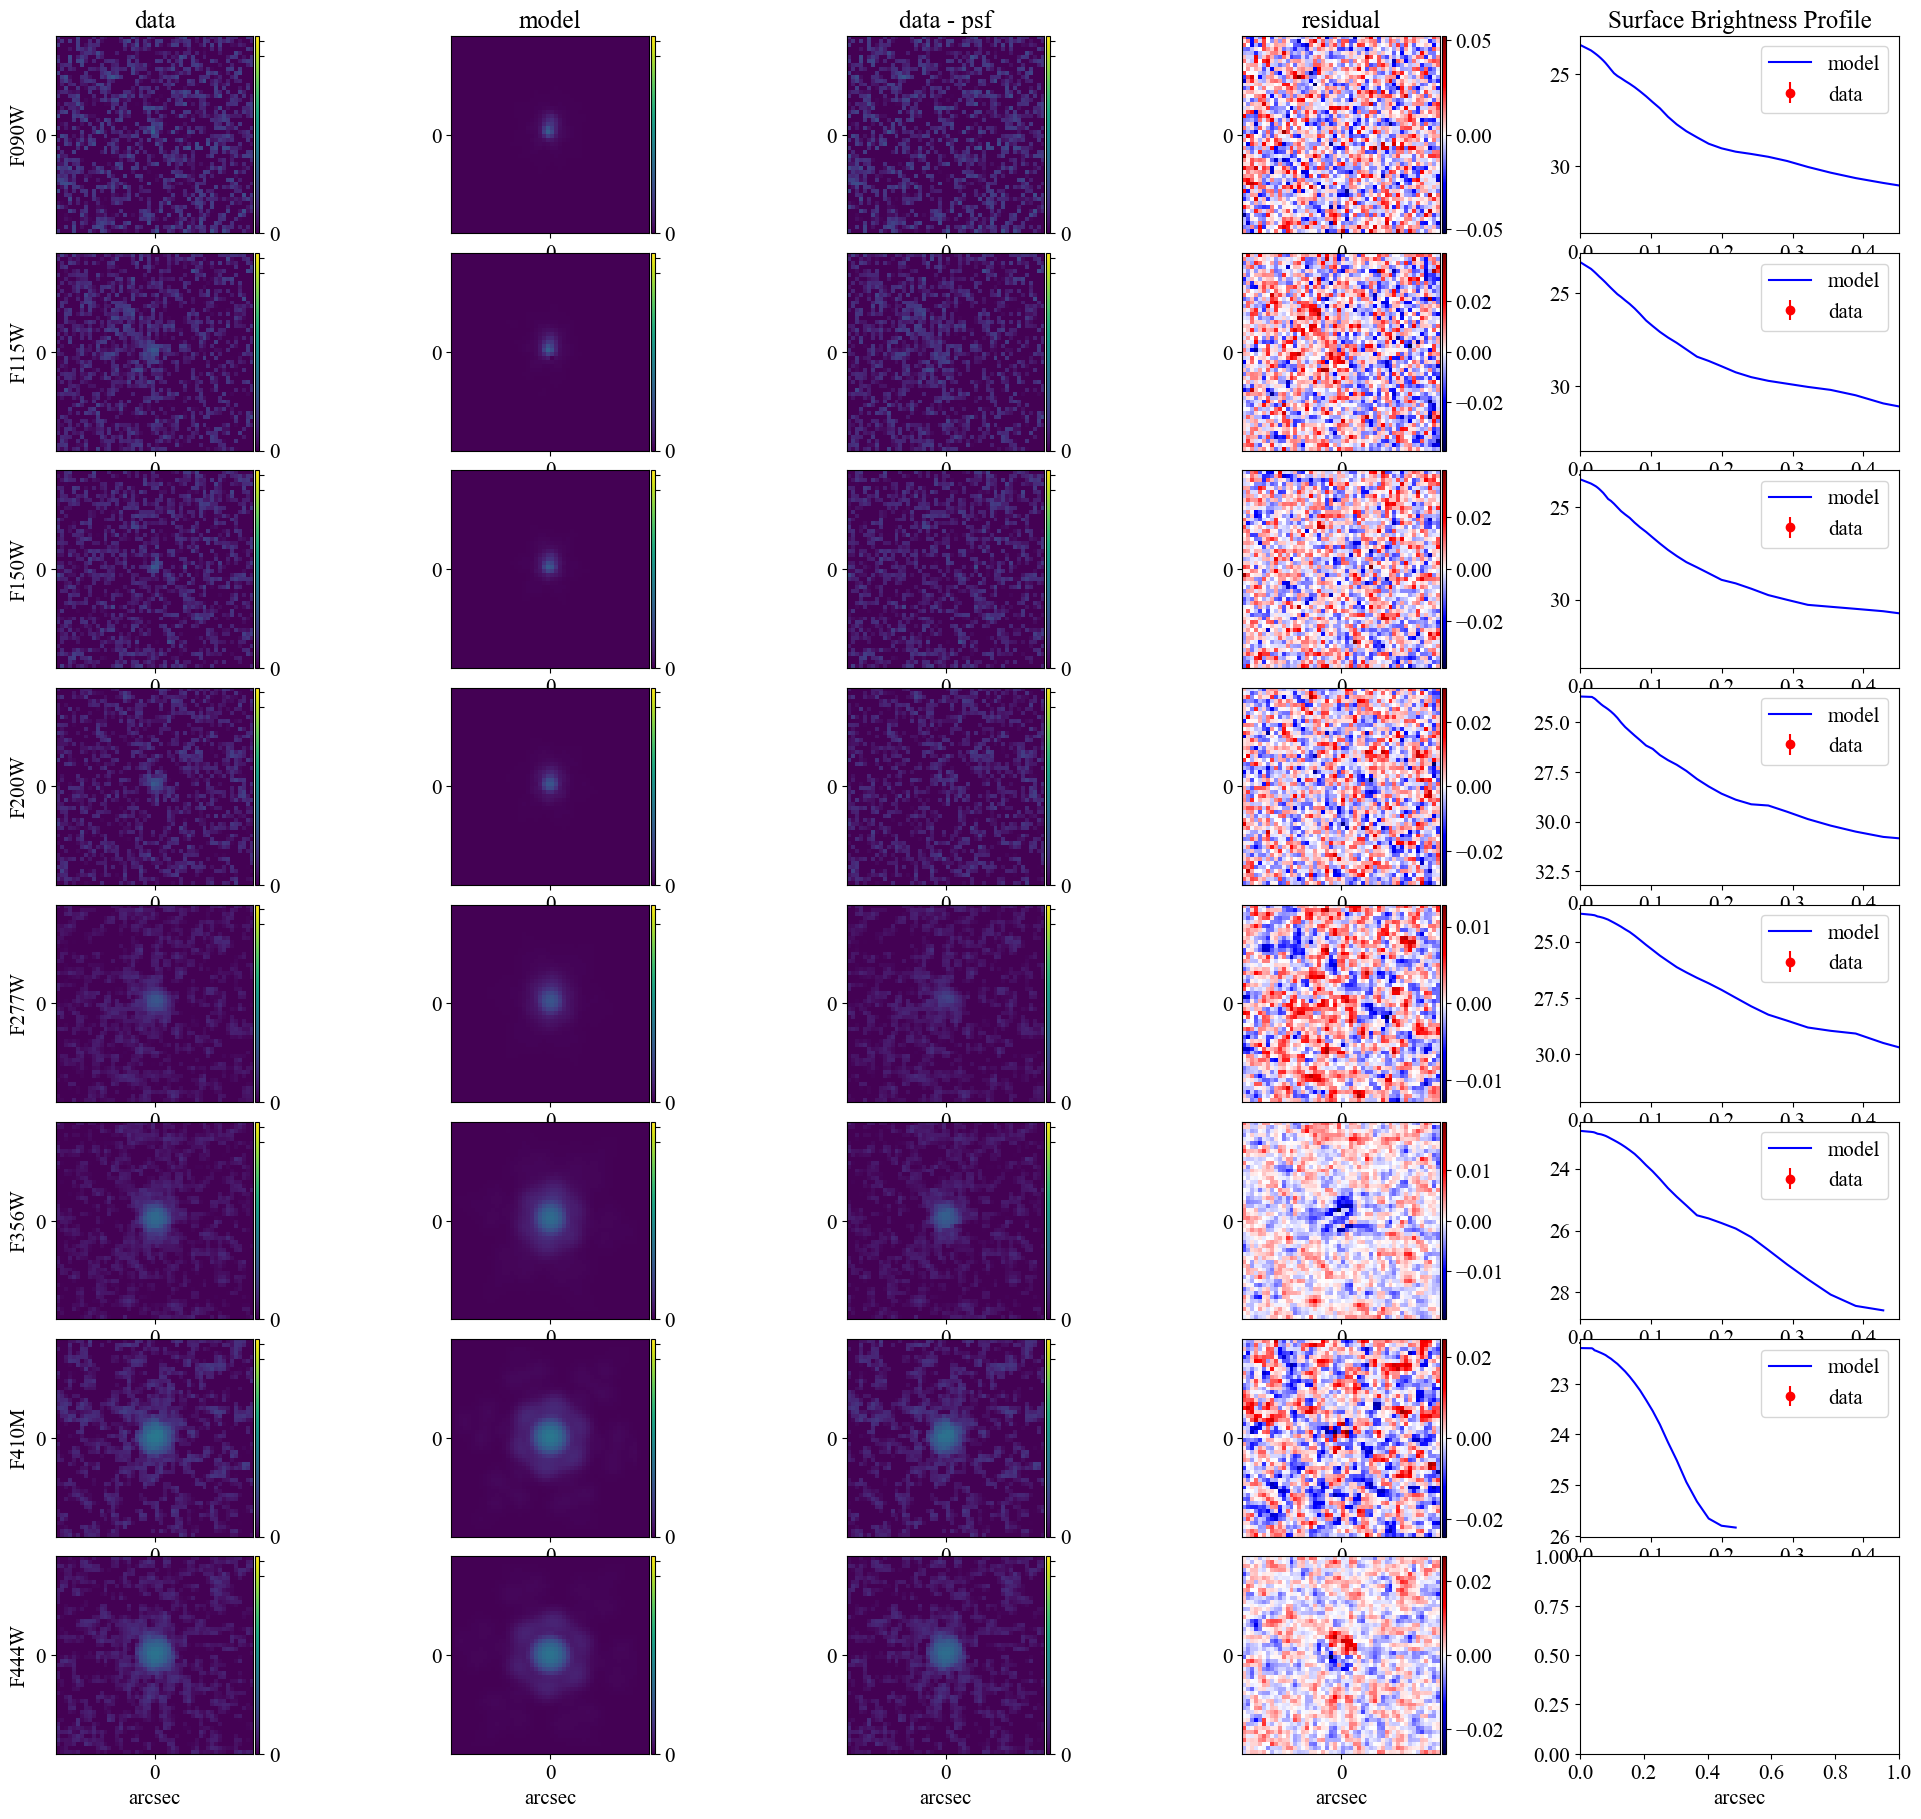

In [4]:
# reload basicfunc


img_path = './'
figure_name = '/Users/zijianzhang/Astro_Data/mag_LRD/Galfitm_decompision/584_result.png'
numid_psf = 1
num_comp = 2
band_names = ['F090W', 'F115W', 'F150W', 'F200W', 'F277W', 'F356W', 'F410M', 'F444W']
pixscale = 0.03
img_idx = band_names[0]
maskfile = '584.mask.fits'
plot_galfitm_res(result_name, figure_name, numid_psf, num_comp, band_names,
                     img_idx, img_path, maskfile, n_gal, pixscale, save=True, show=True)

In [4]:
psf1 = '/Users/zijianzhang/Astro_Data/mag_LRD/galfitm_demo/late_g_psf.fits'
psf2 = '/Users/zijianzhang/Astro_Data/mag_LRD/Galfitm_decompision/584_F356W_psf.fits'
hdu = fits.open(psf1 )
hdu.info()

Filename: /Users/zijianzhang/Astro_Data/mag_LRD/galfitm_demo/late_g_psf.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      45   (35, 35)   float32   


In [11]:
hdu = fits.open(psf2)
hdu.info()

Filename: /Users/zijianzhang/Astro_Data/mag_LRD/Galfitm_decompision/584_F356W_psf.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       9   (201, 201)   float32   


In [6]:
os.system('/Users/zijianzhang/software/galfitm test.feedme')


GALFITM Version galfitm-1.4.4
(based on GALFIT Version 3.0.5)

Error: number of mag zeropoints does not correspond to number of band filenames

#  Input menu file: test.feedme

# IMAGE and GALFIT CONTROL PARAMETERS
A) /Users/zijianzhang/Documents/code/galfitm_demo/early_g_data.fits,/Users/zijianzhang/Documents/code/galfitm_demo/early_r_data.fits,/Users/zijianzhang/Documents/code/galfitm_demo/early_i_data.fits      # Input data image (FITS file)
A1) g,r,i              # Band labels
A2) 0.480,0.620,0.760     # Band wavelengths
B) /Users/zijianzhang/Documents/code/galfitm_demo/test_result.fits      # Output data image block
C) /Users/zijianzhang/Documents/code/galfitm_demo/early_i_weight.fits,/Users/zijianzhang/Documents/code/galfitm_demo/early_i_weight.fits,/Users/zijianzhang/Documents/code/galfitm_demo/early_i_weight.fits 0.000   # Sigma image and min. sigma factor (made from data if blank or "none") 
D) /Users/zijianzhang/Documents/code/galfitm_demo/early_i_psf.fits,/Users/zijianzhang


One or more parameters tried to exceed hard limits
Parameter(s) constrained by hard limits or user-specified constraint(s)
Improved chisq
constr_alamda_factor: 1000.000

Iteration : 1     Chi2nu: 4.22709e+01   dChi2/Chi2: -1.38e+20   alamda: 1e+01     
delchi2/sqrt(chi2nu): 1.54e+26    avghist: 0.00e+00  
 g  : psf       : (  119.98,   119.96)   17.74     ---     ---     ---     ---
 r  : psf       : (  119.97,   119.99)   17.59     ---     ---     ---     ---
 i  : psf       : (  119.96,   120.01)   17.94     ---     ---     ---     ---
 g  : sersic    : (  120.10,   120.23)   18.51     10.19    5.20    0.82   -19.17
 r  : sersic    : (  120.15,   120.45)   18.46     11.96    5.20    0.73   -23.38
 i  : sersic    : (  120.20,   120.68)   18.02      9.98    5.20    0.61   -27.60
 g  : sersic    : (  120.10,   120.23)   18.51     10.19    5.20    0.82   -19.17
 r  : sersic    : (  120.15,   120.45)   18.46     11.96    5.20    0.73   -23.38
 i  : sersic    : (  120.20,   120.68)   18.0

0

In [9]:
import pandas as pd

output_file = "/Users/zijianzhang/Astro_Data/local_LRD_analog/Code/fitting_slope_result.csv"
stored_data = pd.read_csv(output_file)

In [10]:
stored_data

,ID,Z,TARGETID,SW_Beta,SW_Beta_Err,LW_Beta,LW_Beta_Err
0,1.0,0.097813,3.962782e+16,NaN,NaN,1.206566,5.124393
1,9.0,1.255420,3.908984e+16,-3.996082,1.680926,4.552796,13.521477
2,14.0,0.478053,3.908984e+16,-5.965474,4.941025,-0.763354,2.759348
3,123.0,1.226595,2.433170e+14,-0.578249,1.680926,0.241983,13.521609
4,175.0,1.149580,3.908984e+16,-2.165188,1.680927,-0.588794,13.521474
...,...,...,...,...,...,...,...
73295,1399751.0,1.246506,3.908984e+16,-1.171678,0.960689,-2.162406,3.720245
73296,1399758.0,1.191409,3.962785e+16,-0.845826,1.680927,-0.774696,13.521475
73297,1399763.0,0.764561,3.908984e+16,-0.969844,1.220533,-0.936022,5.604359
73298,1399774.0,0.833672,3.962785e+16,1.404926,2.515380,0.383288,2.656165
